In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve)
from sklearn.inspection import permutation_importance
from textwrap import dedent


In [2]:
def read_file(path):
    """
    Reads file
    ----------------------------
    INPUT:
        path: (str)

    OUTPUT:
        (pd.DataFrame)
    """
    try:
        if path.endswith(".csv"):
            return pd.read_csv(path)

        elif path.endswith(".dat"):
            return pd.read_csv(path, sep="\s+")

        else:
            raise ValueError("File must end with .csv or .dat")

    except Exception as err:
        print(f"\nOOPS! -> {err}")

        return None

def eval_classifier(y_true, y_hat, y_prob, label=""):
    """
    Computes classification metrics for binary classification.
    --------------------------------------------------------
    INPUT:
        y_true: (np.ndarray) True binary labels
        y_hat: (np.ndarray) Predicted labels (0/1)
        y_prob: (np.ndarray) Predcited probabilities for positive class (1). USed for ROC-AUC
        label: (str) Label for classification report

    OUTPUT:
        metrics (dict) Accuracy, F1, precision, recall, and roc_auc
    """
    accuracy = accuracy_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    roc_auc = roc_auc_score(y_true, y_prob)

    print(f"\nAccuracy:  {accuracy:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"ROC AUC:   {roc_auc:.3f}")

    print(f"\nClassification Report: {label}")
    print(classification_report(y_true, y_hat))

    # Confusion matrix
    conf_mat = confusion_matrix(y_true, y_hat)
    # Convert to pandas DataFrame
    df_mat = pd.DataFrame(
        conf_mat,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )

    print(f"Confusion Matrix:\n{df_mat}")

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall, "roc_auc": roc_auc}

def cv_threshold(model, X_train, y_train, cv, mode="max_f1", min_recall=0.95):
    """
    Chooses decision threshold on training data via Cross-validation predicted probabilities.
    ------------------------------------------------
    INPUT:
        model: (sklearn) Estimator
        X_train, y_train: (pd.Series) Training data.
        cv: (StratifiedKFold) Cross-validation splitter
        mode: (str) default: 'max_f1' Chooses threshold to maximize F1
        min_recall: (float) Only used when mode="min_recall" (default=0.95)

    OUTPUT:
        best_t: Threshold w/in [0,1]
        df_curve: (pd.DataFrame) Treshold-metric table with columns as "threshold", "precision", "recall", "F1"
    """
    # Cross-validated probabilities
    y_prob_cv = cross_val_predict(
        model,
        X_train,
        y_train,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]

    # Tresholds x-line
    thresholds = np.linspace(0.01, 0.99, 99)

    rows=[]
    # Iterating thru thresholds
    for t in thresholds:
        y_hat_t = (y_prob_cv >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_train, y_hat_t, zero_division=0),
            "recall": recall_score(y_train, y_hat_t),
            "f1": f1_score(y_train, y_hat_t, zero_division=0)
        })

    # Assemble threshold sweep into DataFrame for easy plotting
    df_curve = pd.DataFrame(rows)

    if mode == "max_f1":
        best_row = df_curve.loc[df_curve["f1"].idxmax()]
        best_t = float(best_row["threshold"])

    elif mode == "min_recall":
        # Pick recall w/ max precision
        feasible = df_curve[df_curve["recall"] >= min_recall].copy()

        if feasible.empty:
            # When empty fall back to max_f1
            best_row = df_curve.loc[df_curve["f1"].idxmax()]
            best_t = float(best_row["threshold"])

        else:
            best_row = feasible.loc[feasible["precision"].idxmax()]
            best_t = float(best_row["threshold"])

    else:
        raise ValueError("Mode must be 'max_f1' or 'min_recall'")

    return best_t, df_curve

def plot_roc(y_true, y_prob, title="Model"):
    """
    PLots ROC nad Precision-Recall Curves.
    """
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve - {title}")
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {title}")
    plt.show()

def rf_model(random_state=73):
    """
    Baseline Random Forest model
    """
    return RandomForestClassifier(
        # Number of Decision trees in forest (500)
        n_estimators=500,
        # n_samples / (n_classes * np.bincount(y))
        class_weight="balanced",
        # NO depth limit
        max_depth=None,
        # Subset fo features to consider for best split: sqrt(n_features)
        max_features="sqrt",
        # Minimum number of samples to split (internal node)
        min_samples_split = 2,
        # Samples on right/left branch required for each leaf node
        min_samples_leaf=5, # 5 was chosen to reduce variance (default=1)
        # Random seed for reproducibility
        random_state=73,
        # Out-of-bag score for estimates generalization w/out using test data
        oob_score=True,
        # Use all CPU cores
        n_jobs=-1
    )

def feature_select(features):
    """
    Selects features and outputs the proper features and target
    ----------------------------------------
    INPUT:
        features: (list) List of features to use

    OUTPUT:
        X, y: (tuple: pd.DataFrame, pd.Series)
    """
    # Read file
    df = read_file("data/lung_cancer.csv")

    # isolate relevant features
    X = df[features].copy()
    # Target
    y = df["lung_cancer_risk"].copy()

    # Output features used
    print(f"Features: X.columns=  {X.columns}")

    return X, y

def feature_corr(X, y):
    """
    Outputs feature corelations for user to see.
    ----------------------------------------
    INPUT:
        X: (pd.DataFrame) Features
        y: (pd.Series) Target

    OUTPUT:
        None
    """
    # Correlations of remaining features
    corr_series = pd.concat([X, y],
                            axis=1).corr(numeric_only=True)["lung_cancer_risk"]
    print("\nCorrelation of features with target:")
    print(corr_series.sort_values(ascending=False))

def data_split(X, y, test_size=0.2):
    """
    Splits data into training/test datasets based on test size.
    ------------------------------------------------
    INPUT:
        X: (pd.DataFrame) Features
        y: (pd.Series) Target
        test_size: (float) Split ratio (default: 20/80 for test/train)

    OUTPUT:
        X_train, X_test, y_train, y_test: (tuple)
    """
    X_train, X_test, y_train, y_test = \
            train_test_split(
                X,
                y,
                # For 20/80 test/train split
                test_size=test_size,
                # Random seed for reproducibility
                random_state=73,
                # Deals w/ class imbalance
                stratify=y
            )

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Class balance:")
    print(y_train.value_counts(normalize=True))

    return X_train, X_test, y_train, y_test

def cv_auc_score(
    model_obj,
    X_train,
    y_train,
    n_splits=5,
    scoring="roc_auc"
):
    """
    Fits Random Forest on training set, reports out-of-bag (OOB) score, then estimates generalization via Stratified K-Fold cross-validation.
    Chooses probability thresholds using CV predicted probabilities for best F1 and best Recall.
    -------------------------------------------------------
    INPUT:
        model_obj: (sklearn.ensemble._forest.RandomForestClassifier) Random Forest Classifier model object
        X_train: (pd.DataFrame) Training data
        y_train: (pd.Series) Target training data
        n_splits: (int) Number of CV folds (default=5)
        scoring: (str) sklearn scoring name (default="roc_auc")

    OUTPUT:
        cv_auc: (np.ndarray) Length of n_splits array of CV scores.
        best_t_f1: (float) Threshold maximizes F1 on CV predictions
        curve_f1: (pd.DataFrame) Threshold metrics for max_f1 mode
        best_t_recall: (float) Threshold selected under recall
        curve_recall: (pd.DataFrame) Threshold metrics for min_recall mode
        
    """
    # Build ze trees wiz ze training data
    model_obj.fit(X_train, y_train)

    # Output Out-of-bag score
    print(f"\nOOB Score: {model_obj.oob_score_:.3f}")

    # Cross-validation AUC
    cv = StratifiedKFold(
        # NUmber of folds; preserving class proportions in each fold
        n_splits=n_splits,
        # Shuffles each class's samples prior to splitting
        shuffle=True,
        # Random seed for reproducibliity
        random_state=73
    )

    # Cross-validation AUC score
    cv_auc = cross_val_score(
        model_obj,
        X_train,
        y_train,
        # Evaluate performance of estimator across splits
        scoring=scoring,
        # Splitting strategy chosen
        cv=cv,
        # USing all CPU cores
        n_jobs=-1
    )

    # Output Results for user
    print("\nCross-validation ROC-AUC:")
    print(f"mean={cv_auc.mean():.3f}")
    print(f"std={cv_auc.std():.3f}")
    print(f"scores={np.round(cv_auc, 3)}")

    # Choose threshold using Cross-validation
    # Max F1 Score
    best_t_f1, curve_f1 = cv_threshold(
        model_obj,
        X_train,
        y_train,
        cv=cv,
        mode="max_f1"
    )

    # Min Recall
    best_t_recall, curve_recall = cv_threshold(
        model_obj,
        X_train,
        y_train,
        cv=cv,
        mode="min_recall"
    )

    # Results
    print("\nThreshold selection via Cross-validation")
    print(f"Best threshold (F1): {best_t_f1:.2f}")
    print(f"best threshold (Recall): {best_t_recall:.2f}")

    return cv_auc, best_t_f1, curve_f1, best_t_recall, curve_recall

def make_predictions(model, X_test, y_test):
    """
    Probability predictions on the test set, then evaluates thhree decision rules:
        1) Default threshold (t=1/2)
        2) Threshold for Max F1
        3) Threshold for Min Recall

    --> This function uses global variables (best_t_f1, best_t_recall) defined in main area
    ------------------------------------------------
    INPUT:
        model: (sklearn.ensemble._forest.RandomForestClassifier) Must be fitted
        already on training data.
        X_test: (pd.DataFrame) Test data
        y_test: (pd.Series) Target test data

    OUTPUT:
        y_prob: (np.ndarray) Positive-class probs for test set
        y_hat: (np.ndarray) Predictions using t=1/2
        y_hat_f1: (np.ndarray) Predictions using MAx F1
        y_hat_recall: (np.ndarray) Predications using Min Recall
    """
    # Predict class probabilities, returning an array of shape (n_samples,
    # n_classes), where we care about CLASS, hence the [:,1]
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluating default threshold (1/2)
    # Converting array of boolean values to 0/1 with astype(int)
    y_hat = (y_prob >= 0.50).astype(int)

    # Evaluating Max F1
    y_hat_f1 = (y_prob >= best_t_f1).astype(int)
    eval_classifier(y_test, y_hat_f1, y_prob, label=f"Random Forest (Max F1) = {best_t_f1:.2f}")

    # Evaluate @ min_recall
    y_hat_recall = (y_prob >= best_t_recall).astype(int)
    eval_classifier(y_test, y_hat_recall, y_prob, label=f"Random Forest (threshold = {best_t_recall:.2f}, picked by CV recall>=0.95)")

    # PLotting
    plot_roc(y_test, y_prob, title="Random Forest (Test)")

    return y_prob, y_hat, y_hat_f1, y_hat_recall

# ====== Significance Testing ==========
def sig_test(
    cv_auc,
    mu0=0.50,
    alpha=0.05,
    model="Random Forest"):
    """
    One-sided Z-test via Normal Approx. for whether mean CV ROC-AUC goes beyond chance.
    Hypothesese:
        H0 -> E[AUC] = mu0 (1/2 for random guessing)
        H1 -> E[AUC] > mu0

    Treats the fold scores as an Independent and identically distributed sample with mean E[AUC].
    ------------------------------------------
    INPUT:
        cv_auc: (np.ndarray) ROC-AUC scores from 5-fold StratifiedKFOld
        cross-validation.
        mu0: (float) Null mean AUC (default=0.50)
        alpha: (float) Significance Level
        model: (str) Model used for user output (default: Random Forest)

    OUTPUT:
        None
    """
    # Sample Stats
    auc_bar = cv_auc.mean()
    auc_sd = cv_auc.std(ddof=1)
    n = len(cv_auc)

    # Standard Error
    se = auc_sd / np.sqrt(n)

    # Z-stat (large sample approx)
    Z = (auc_bar - mu0) / se

    # p-value
    p_val = 1 - norm.cdf(Z)

    # User output
    print(f"\nH0: AUC mu={mu0}")
    print(f"Standard Deviation (CV): {auc_sd:.3f}")
    print(f"Standard Error: {se:.3f}")
    print(f"Z stat: {Z:.3f}")
    print(f"p-value: {p_val:.3f}")

    # Result
    if p_val < alpha:
        print(dedent(f"""
Reject Null Hypothesis
{model} performs better than random chance.  ᕙ(▀̿ĺ̯▀̿ ̿)ᕗ
                     """))
    else:
        print(dedent(f"""
\nFail to reject null hypothesis.
{model} doesn't provide sufficient evidence that it does better than chance.   ( ͡ಥ ͜ʖ ͡ಥ)
                     """))


Features: X.columns=  Index(['age', 'pack_years', 'copd', 'family_history_cancer', 'chronic_cough',
       'shortness_of_breath', 'oxygen_saturation'],
      dtype='object')

Training set: 4000 samples
Test set: 1000 samples
Class balance:
lung_cancer_risk
0    0.75125
1    0.24875
Name: proportion, dtype: float64

Correlation of features with target:
lung_cancer_risk         1.000000
pack_years               0.830688
shortness_of_breath      0.659022
chronic_cough            0.629583
copd                     0.616377
age                      0.083533
family_history_cancer    0.063177
oxygen_saturation       -0.766323
Name: lung_cancer_risk, dtype: float64

OOB Score: 0.944

Cross-validation ROC-AUC:
mean=0.990
std=0.003
scores=[0.992 0.992 0.989 0.993 0.985]

Threshold selection via Cross-validation
Best threshold (F1): 0.61
best threshold (Recall): 0.52

Accuracy:  0.959
F1 Score:  0.921
Precision: 0.882
Recall:    0.964
ROC AUC:   0.993

Classification Report: Random Forest (Max F1)

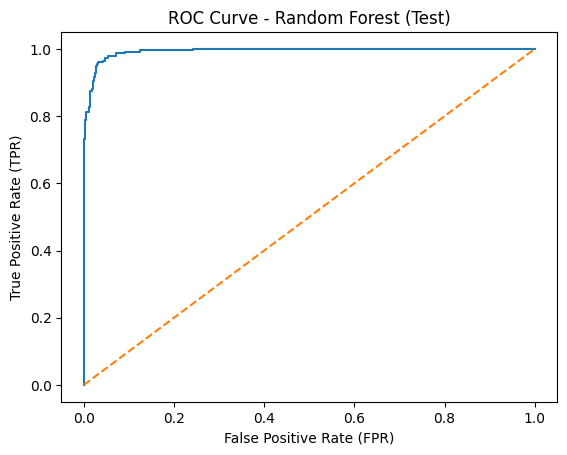

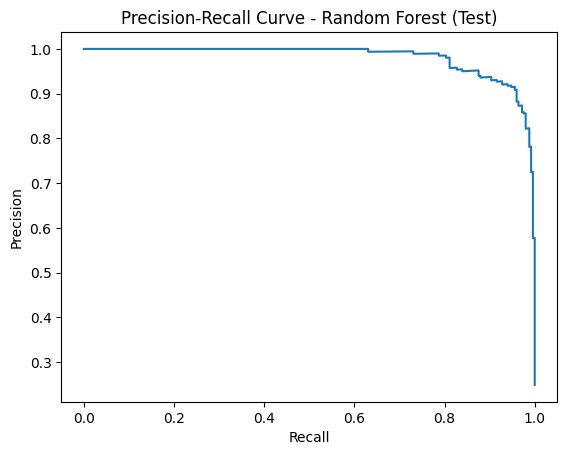


H0: AUC mu=0.5
Standard Deviation (CV): 0.003
Standard Error: 0.001
Z stat: 343.514
p-value: 0.000

Reject Null Hypothesis
Random Forest performs better than random chance.  ᕙ(▀̿ĺ̯▀̿ ̿)ᕗ



In [3]:
df = read_file("data/lung_cancer.csv")

# Target and features
# Confounding features: pack_years = (cigs_per_day/20) * smoking_years
X,y = feature_select(['age','pack_years','copd','family_history_cancer','chronic_cough', 'shortness_of_breath', 'oxygen_saturation'])

# Split data into train/test sets
X_train, X_test, y_train, y_test = data_split(X, y)

# Output Feature correlations
feature_corr(X, y)

# Fitting Random Forest Classifier
# Unlike Logistic Regression, scaling is NOT required because trees split on thresholds so feature magnitudes don't affect the splits.
forest = rf_model()

# Output Cross-validation AUC results w/ results returned just because  ¯\_( ͡° ͜ʖ ͡°)_/¯
cv_auc, best_t_f1, curve_f1, best_t_recall, curve_recall = cv_auc_score(forest, X_train, y_train)

# Predictions!
y_prob, y_hat, y_hat_f1, y_hat_recall = make_predictions(
    forest,
    X_test,
    y_test
)

# ======== Significance Test =============
sig_test(cv_auc)
